# Depth Estimator Visualization

Visualize the results from the depth estimator inference on random dataset images.

Start by importing the model builder and building the model with the previously trained weights.

In [4]:
import sys
sys.path.append("../")
from multitudinous.utils.model_builder import build_img_pretraining
import torch

MODEL_NAME = "se_resnet50_unet"

# build the model
model = build_img_pretraining(MODEL_NAME, 3, "../output_depth_estimation/depth_estimator_40.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

# print the model
print(model)

ResNetAutoEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

Now we need to import the dataset builder and build the dataset.

In [5]:
from multitudinous.utils.dataset_builder import build_img_dataset
from torch.utils.data import DataLoader

# build the dataset
dataset = build_img_dataset("tum_rgbd", "../../data/tum_rgbd1")

# create the dataloader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Now, run inference and visualize on "x" random samples from the dataset.

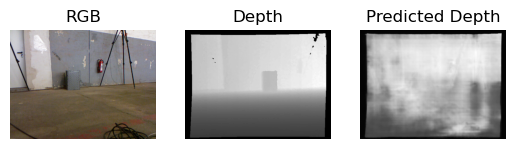

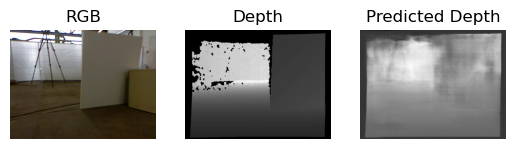

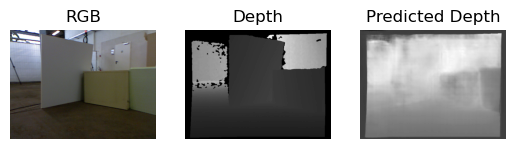

In [6]:
import matplotlib.pyplot as plt
import torch

# initialize loggers
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

NUM_SAMPLES = 3

# pick "NUM_SAMPLES" samples
samples = [next(iter(dataloader)) for _ in range(NUM_SAMPLES)]

# run inference on the samples
for rgb, depth in samples:

    pred = None

    # build the rgb-d sample
    rgb = rgb.to(device)
    depth = depth.to(device)
    
    # run inference
    with torch.no_grad():
        starter.record() # start recording
        # move the sample to the device
        pred = model(rgb)
        ender.record() # end recording
        if device == torch.device('cuda'):
            torch.cuda.synchronize() # wait for gpu sync
            
    rgb = rgb.squeeze()

    # plot the results
    plt.subplot(1, 3, 1)
    plt.imshow(rgb.permute(1, 2, 0).cpu())
    plt.title("RGB")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(depth.squeeze(0).cpu(), cmap="gray")
    plt.title("Depth")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze().detach().cpu(), cmap="gray")
    plt.title("Predicted Depth")
    plt.axis("off")
    plt.show()

    del pred, rgb, depth

# clean up
del model, dataset, dataloader